In [2]:
# CHANGE ME: Set this to the path to the NuPlan data directory
NUPLAN_DATA_PATH = "~/nuplan-v1.1/splits/mini/"

In [22]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    timestamp: float
    quaternion: npt.NDArray[np.float64]
    velocity: npt.NDArray[np.float64]
    position: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [23]:
import os
trajectories: list[list[State]] = []

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

file_iter = iter(getFiles(NUPLAN_DATA_PATH))

In [24]:
import sqlite3

for file_path in file_iter:
    trajectory = []
    with sqlite3.connect(file_path) as conn:
        cur = conn.cursor()
        for (timestamp, vx, vy, vz, qw, qx, qy, qz, x, y, z) in cur.execute("SELECT timestamp, vx, vy, vz, qw, qx, qy, qz, x, y, z FROM ego_pose"):
            s = State(timestamp=timestamp, quaternion=np.array([qx, qy, qz, qw]), velocity=np.array([vx, vy, vz]), position=np.array([x, y, z]))
            trajectory.append(s)
    trajectories.append(trajectory)
    print(f"Loaded trajectory of len {len(trajectory)} from {file_path}")

Loaded trajectory of len 48525 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.08.17.17.17.01_veh-45_02314_02798.db
Loaded trajectory of len 36197 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.05.07.10.04_veh-52_01442_01802.db
Loaded trajectory of len 38438 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.09.12.39.51_veh-26_05620_06003.db
Loaded trajectory of len 39790 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.08.30.14.54.34_veh-40_00439_00835.db
Loaded trajectory of len 18494 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.11.02.57.41_veh-50_00352_00535.db
Loaded trajectory of len 45185 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.28.15.02.02_veh-38_02398_02848.db
Loaded trajectory of len 39394 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.06.07.26.10_veh-52_00006_00398.db
Loaded trajectory of len 46200 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.09.17.37.09_veh-12_00404_00864.db
Loaded trajectory of len 55090 f

KeyboardInterrupt: 

In [ ]:
# z is up, x is forward, y is left

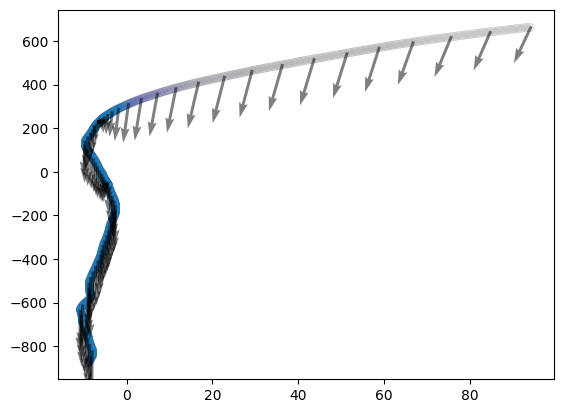

In [25]:
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

subsection = trajectories[5][:20000]


xs = np.array([s.position[0] for s in subsection])
ys = np.array([s.position[1] for s in subsection])
zs = np.array([s.position[2] for s in subsection])

xs -= np.mean(xs)
ys -= np.mean(ys)
zs -= np.mean(zs)

rs = [Rotation.from_quat(s.quaternion) for s in subsection]

qintv = 200

qxs = np.array([xs[i] for i in range(len(ys)) if i % qintv == 0])
qys = np.array([ys[i] for i in range(len(ys)) if i % qintv == 0])
qxvs, qyvs = np.stack([rs[i].apply(subsection[i].velocity) for i in range(len(xs)) if i % qintv == 0])[:, :2].T


plt.scatter(xs, ys, alpha=0.005)
plt.quiver(qxs, qys, qxvs, qyvs, alpha=0.5)
plt.show()

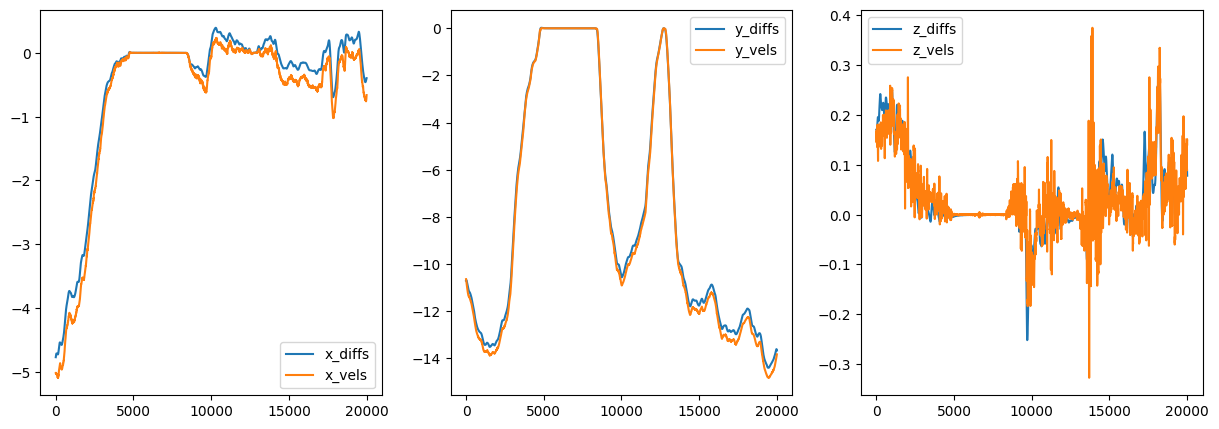

In [36]:
from scipy.ndimage import gaussian_filter1d

subsection = trajectories[5][:20000]

x_diffs_a: list[float] = []
x_vels_a: list[float] = []

y_diffs_a: list[float] = []
y_vels_a: list[float] = []

z_diffs_a: list[float] = []
z_vels_a: list[float] = []

for i in range(len(subsection)-1):
    s0 = subsection[i]
    s1 = subsection[i+1]

    r = Rotation.from_quat(s0.quaternion)    
    global_v = r.apply(s0.velocity)

    x_diffs_a.append(s1.position[0] - s0.position[0])
    x_vels_a.append(global_v[0])

    y_diffs_a.append(s1.position[1] - s0.position[1])
    y_vels_a.append(global_v[1])

    z_diffs_a.append(s1.position[2] - s0.position[2])
    z_vels_a.append(global_v[2])


x_diffs = np.array(x_diffs_a)
x_vels = np.array(x_vels_a)
y_diffs = np.array(y_diffs_a)
y_vels = np.array(y_vels_a)
z_diffs = np.array(z_diffs_a)
z_vels = np.array(z_vels_a)



x_diffs:np.ndarray = gaussian_filter1d(x_diffs, 30, mode='nearest')
x_diffs *= 100


y_diffs:np.ndarray = gaussian_filter1d(y_diffs, 30, mode='nearest')
y_diffs *= 100


z_diffs:np.ndarray = gaussian_filter1d(z_diffs, 30, mode='nearest')
z_diffs *= 100




plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_diffs, label='x_diffs')
plt.plot(x_vels, label='x_vels')
plt.legend()    

plt.subplot(1, 3, 2)
plt.plot(y_diffs, label='y_diffs')
plt.plot(y_vels, label='y_vels')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(z_diffs, label='z_diffs')
plt.plot(z_vels, label='z_vels')
plt.legend()


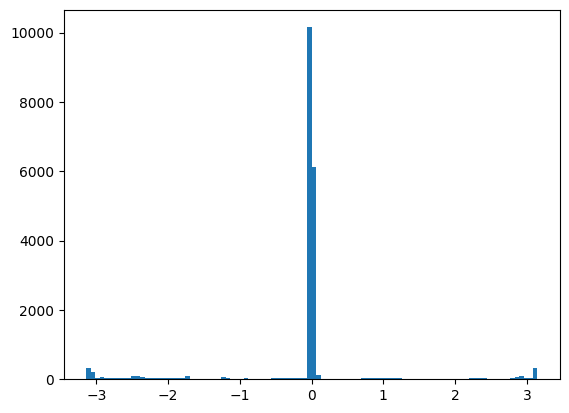

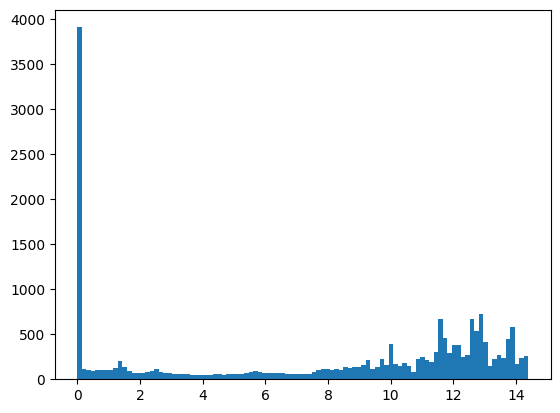

In [28]:
import numpy as np

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi


headings = [Rotation.from_quat(s.quaternion).as_euler('xyz')[2] for s in subsection[:-1]]

hdiffs = []
vmags = []

for heading, vx, vy in zip(headings, x_diffs, y_diffs):
    veldir = np.arctan2(vy, vx)
    hdiff = normalize_angle(heading - veldir)
    hdiffs.append(hdiff)
    vmags.append(np.sqrt(vx**2 + vy**2))

hdiffs_arr = np.array(hdiffs)

plt.hist(hdiffs_arr, bins=100)
plt.show()
plt.hist(vmags, bins=100)
plt.show()

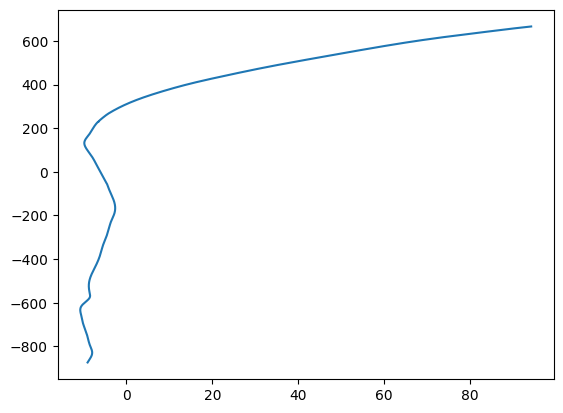

In [115]:
from scipy.interpolate import UnivariateSpline

timestamps = np.array([s.timestamp for s in subsection])
x_src = np.array([s.position[0] for s in subsection])
y_src = np.array([s.position[1] for s in subsection])

x_src -= x_src.mean()
y_src -= y_src.mean()

x_spline = UnivariateSpline(timestamps, x_src, k=4, s=10)
y_spline = UnivariateSpline(timestamps, y_src, k=4, s=10)

sampled_timestamps = np.arange(timestamps[0], timestamps[-1], 100_000)

x_sampled = x_spline(sampled_timestamps)
y_sampled = y_spline(sampled_timestamps)

plt.plot(x_sampled, y_sampled)

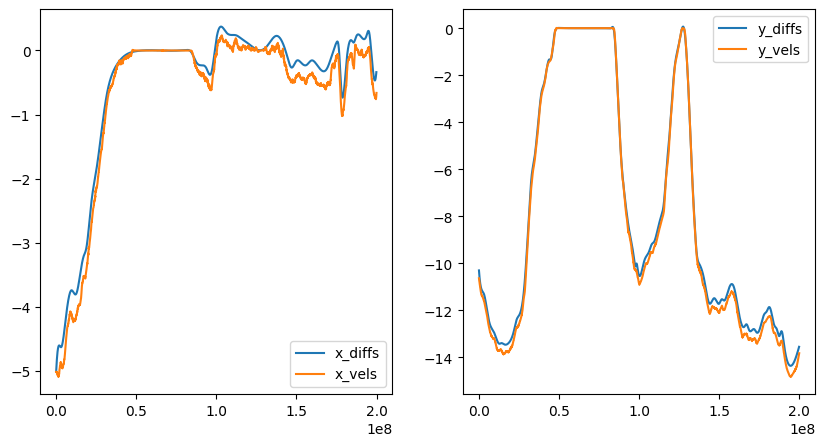

In [116]:
xvel_spline = x_spline.derivative()(sampled_timestamps)*1_000_000
yvel_spline = y_spline.derivative()(sampled_timestamps)*1_000_000

start_time = timestamps[0]
sampled_timestamps_at_zero = np.array(sampled_timestamps) - start_time
timestamps_at_zero = np.array(timestamps[:-1]) - start_time

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sampled_timestamps_at_zero, xvel_spline, label='x_diffs')
plt.plot(timestamps_at_zero, x_vels, label='x_vels')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(sampled_timestamps_at_zero, yvel_spline, label='y_diffs')
plt.plot(timestamps_at_zero, y_vels, label='y_vels')
plt.legend()


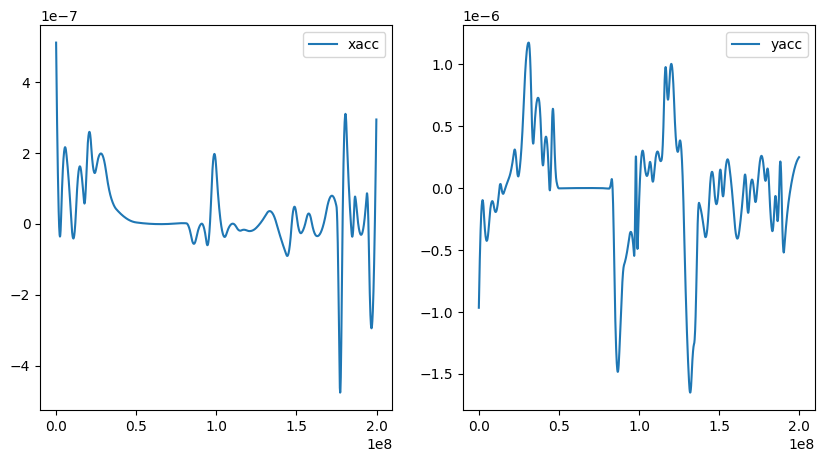

In [117]:
xacc_spline = x_spline.derivative(2)(sampled_timestamps)*1_000_000
yacc_spline = y_spline.derivative(2)(sampled_timestamps)*1_000_000

start_time = timestamps[0]
sampled_timestamps_at_zero = np.array(sampled_timestamps) - start_time

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sampled_timestamps_at_zero, xacc_spline, label='xacc')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(sampled_timestamps_at_zero, yacc_spline, label='yacc')
plt.legend()

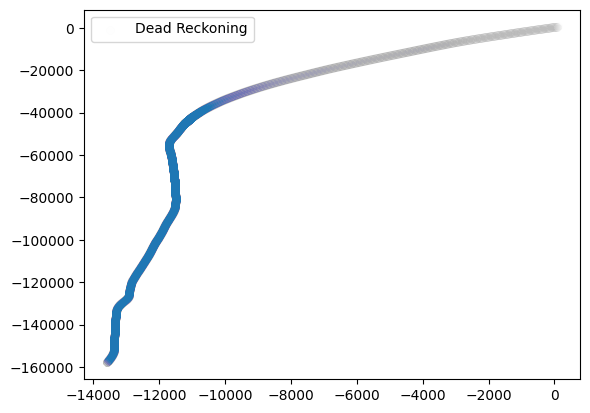

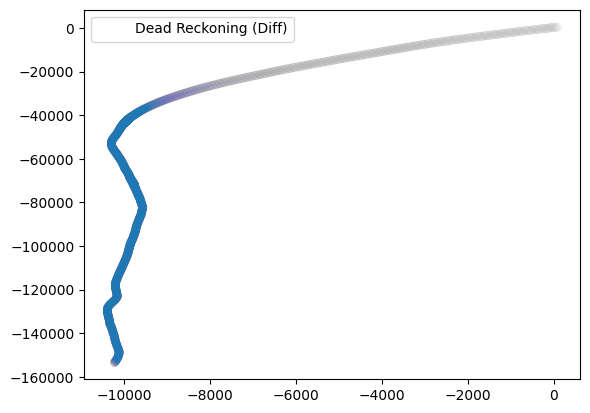

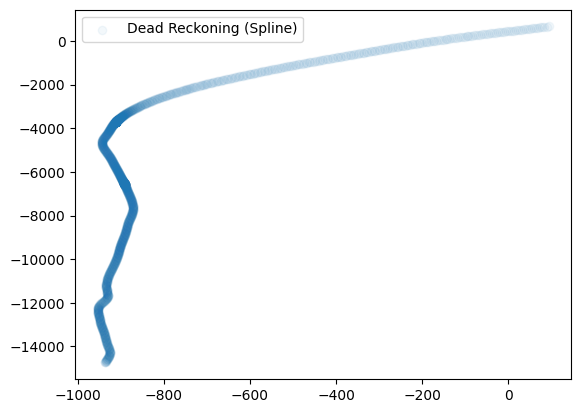

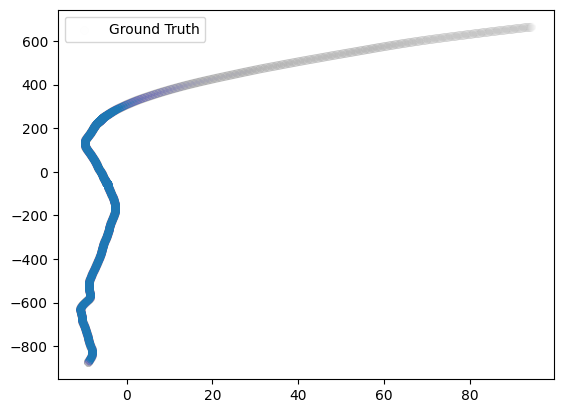

: 

In [118]:
xs = np.array([s.position[0] for s in subsection[:-1]])
ys = np.array([s.position[1] for s in subsection[:-1]])

xs -= np.mean(xs)
ys -= np.mean(ys)

dead_reckoned_xs_vel = [xs[0]]
dead_reckoned_ys_vel = [ys[0]]

dead_reckoned_xs_diff = [xs[0]]
dead_reckoned_ys_diff = [ys[0]]

dead_reckoned_xs_spline = [xs[0]]
dead_reckoned_ys_spline = [ys[0]]

for i in range(1, len(xs)):
    dead_reckoned_xs_vel.append(dead_reckoned_xs_vel[-1] + x_vels[i])
    dead_reckoned_ys_vel.append(dead_reckoned_ys_vel[-1] + y_vels[i])

    dead_reckoned_xs_diff.append(dead_reckoned_xs_diff[-1] + x_diffs[i])
    dead_reckoned_ys_diff.append(dead_reckoned_ys_diff[-1] + y_diffs[i])


for i in range(1, len(xvel_spline)):
    dead_reckoned_xs_spline.append(dead_reckoned_xs_spline[-1] + xvel_spline[i])
    dead_reckoned_ys_spline.append(dead_reckoned_ys_spline[-1] + yvel_spline[i])

plt.scatter(dead_reckoned_xs_vel, dead_reckoned_ys_vel, label='Dead Reckoning', alpha=0.002)
plt.legend()
plt.show()
plt.scatter(dead_reckoned_xs_diff, dead_reckoned_ys_diff, label='Dead Reckoning (Diff)', alpha=0.002)
plt.legend()
plt.show()
plt.scatter(dead_reckoned_xs_spline, dead_reckoned_ys_spline, label='Dead Reckoning (Spline)', alpha=0.05)
plt.legend()
plt.show()
plt.scatter(xs, ys, label='Ground Truth', alpha=0.002)
plt.legend()
plt.show()

In [110]:
len(xvel_spline)

200